# Age, Gender & Expression Recognizer

## 1. Setup and Preparation

### 1.1 Import Libraries and Setting Up Device-agnostic code

In [1]:
import torch
import pandas as pd
import random

from torch import nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Configuration

In [3]:
data_path = Path('/kaggle/input/')

AGE_FILE_PATH = data_path / 'facial-age'
EMOTION_FILE_PATH = data_path / 'facial-emotion-expressions'
GENDER_FILE_PATH = data_path / 'biggest-genderface-recognition-dataset'

train_emotion_dir = EMOTION_FILE_PATH / 'images/train'
test_emotion_dir = EMOTION_FILE_PATH / 'images/validation'

In [4]:
AGE_FILE_PATH, EMOTION_FILE_PATH, GENDER_FILE_PATH

(PosixPath('/kaggle/input/facial-age'),
 PosixPath('/kaggle/input/facial-emotion-expressions'),
 PosixPath('/kaggle/input/biggest-genderface-recognition-dataset'))

### 1.3 Load Datasets

In [5]:
import os

def walk_throuhg_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
# walk_throuhg_dir(AGE_FILE_PATH)

In [7]:
# walk_throuhg_dir(EMOTION_FILE_PATH)

In [8]:
walk_throuhg_dir(GENDER_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/biggest-genderface-recognition-dataset
There are 2 directories and 0 images in /kaggle/input/biggest-genderface-recognition-dataset/faces
There are 0 directories and 17678 images in /kaggle/input/biggest-genderface-recognition-dataset/faces/man
There are 0 directories and 9489 images in /kaggle/input/biggest-genderface-recognition-dataset/faces/woman


## 2. Data Exploration and Preprocessing

In [9]:
def convert_to_df(data_path, name_category):
    paths = [path for path in data_path.rglob('*/*') if path.suffix.lower() in ['.jpg', '.png']]

    # Create the DataFrame with relevant columns
    df = pd.DataFrame({
        'file_path': paths,
        'file_name': [path.name for path in paths],  # Extract file name
         name_category: [path.parts[-2] for path in paths]  # Extract folder name as label
    })
    return df

In [10]:
# Age Dataset
age_df = convert_to_df(AGE_FILE_PATH, name_category='age')
print(age_df.head())

# Gender Dataset
gender_df = convert_to_df(GENDER_FILE_PATH, name_category='gender')
print(gender_df.head())

                                        file_path file_name  age
0  /kaggle/input/facial-age/face_age/057/6802.png  6802.png  057
1  /kaggle/input/facial-age/face_age/057/3702.png  3702.png  057
2  /kaggle/input/facial-age/face_age/057/8810.png  8810.png  057
3  /kaggle/input/facial-age/face_age/057/6759.png  6759.png  057
4  /kaggle/input/facial-age/face_age/057/1846.png  1846.png  057
                                           file_path      file_name gender
0  /kaggle/input/biggest-genderface-recognition-d...   man_4160.jpg    man
1  /kaggle/input/biggest-genderface-recognition-d...  man_16738.jpg    man
2  /kaggle/input/biggest-genderface-recognition-d...   man_4001.jpg    man
3  /kaggle/input/biggest-genderface-recognition-d...   man_4435.jpg    man
4  /kaggle/input/biggest-genderface-recognition-d...  man_12722.jpg    man


In [11]:
# Train Emotion Dataset
train_emotion_df = convert_to_df(train_emotion_dir, name_category='emotion')
train_emotion_df.head()

,file_path,file_name,emotion
0,/kaggle/input/facial-emotion-expressions/image...,30778.jpg,surprise
1,/kaggle/input/facial-emotion-expressions/image...,22706.jpg,surprise
2,/kaggle/input/facial-emotion-expressions/image...,20513.jpg,surprise
3,/kaggle/input/facial-emotion-expressions/image...,27582.jpg,surprise
4,/kaggle/input/facial-emotion-expressions/image...,33678.jpg,surprise


In [12]:
train_emotion_df['file_path'][0]

PosixPath('/kaggle/input/facial-emotion-expressions/images/train/surprise/30778.jpg')

In [13]:
# Test Emotion Dataset
test_emotion_df = convert_to_df(test_emotion_dir, name_category='emotion')
test_emotion_df.head()

,file_path,file_name,emotion
0,/kaggle/input/facial-emotion-expressions/image...,13288.jpg,surprise
1,/kaggle/input/facial-emotion-expressions/image...,24201.jpg,surprise
2,/kaggle/input/facial-emotion-expressions/image...,26556.jpg,surprise
3,/kaggle/input/facial-emotion-expressions/image...,26076.jpg,surprise
4,/kaggle/input/facial-emotion-expressions/image...,27577.jpg,surprise


In [14]:
test_emotion_df['file_path'][0]

PosixPath('/kaggle/input/facial-emotion-expressions/images/validation/surprise/13288.jpg')

In [15]:
age_df.shape, gender_df.shape, train_emotion_df.shape, test_emotion_df.shape

((19556, 3), (27167, 3), (28821, 3), (7066, 3))

In [16]:
# Droping duplicated values in age dataset
print(age_df.duplicated(['file_name', 'age']).sum())
age_df.drop_duplicates(['file_name', 'age'], inplace=True)

# Droping duplicated values in gender dataset
print(gender_df.duplicated(['file_name', 'gender']).sum())
gender_df.drop_duplicates(['file_name', 'gender'], inplace=True)

# Droping duplicated values in train emotion dataset
print(train_emotion_df.duplicated(['file_name', 'emotion']).sum())
train_emotion_df.drop_duplicates(['file_name', 'emotion'], inplace=True)

# Droping duplicated values in test emotion dataset
print(test_emotion_df.duplicated(['file_name', 'emotion']).sum())
test_emotion_df.drop_duplicates(['file_name', 'emotion'], inplace=True)

9778
0
0
0


In [17]:
age_df.shape, gender_df.shape

((9778, 3), (27167, 3))

In [18]:
# Define bins and labels
age_bins = [0, 3, 12, 19, 28, 55, 70]
age_labels = ['Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)

# Assign age categories based on bins
age_df['age_category'] = pd.cut(age_df['age'].astype(int), bins=age_bins, labels=age_labels, right=False)
age_df.head()

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}


,file_path,file_name,age,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057,Elderly


In [19]:
gender_df['gender'] = gender_df['gender'].str.lower()
gender_df.head()

,file_path,file_name,gender
0,/kaggle/input/biggest-genderface-recognition-d...,man_4160.jpg,man
1,/kaggle/input/biggest-genderface-recognition-d...,man_16738.jpg,man
2,/kaggle/input/biggest-genderface-recognition-d...,man_4001.jpg,man
3,/kaggle/input/biggest-genderface-recognition-d...,man_4435.jpg,man
4,/kaggle/input/biggest-genderface-recognition-d...,man_12722.jpg,man


In [20]:
print(age_df.isnull().sum())
age_df.dropna(inplace=True)

print(gender_df.isnull().sum())
gender_df.dropna(inplace=True)

print(train_emotion_df.isnull().sum())
train_emotion_df.dropna(inplace=True)

print(test_emotion_df.isnull().sum())
test_emotion_df.dropna(inplace=True)

file_path         0
file_name         0
age               0
age_category    794
dtype: int64
file_path    0
file_name    0
gender       0
dtype: int64
file_path    0
file_name    0
emotion      0
dtype: int64
file_path    0
file_name    0
emotion      0
dtype: int64


In [21]:
train_emotion_df.drop(train_emotion_df[train_emotion_df['emotion'] == 'disgust'].index, inplace=True)
print(train_emotion_df.shape)
train_emotion_df.head()

(28385, 3)


,file_path,file_name,emotion
0,/kaggle/input/facial-emotion-expressions/image...,30778.jpg,surprise
1,/kaggle/input/facial-emotion-expressions/image...,22706.jpg,surprise
2,/kaggle/input/facial-emotion-expressions/image...,20513.jpg,surprise
3,/kaggle/input/facial-emotion-expressions/image...,27582.jpg,surprise
4,/kaggle/input/facial-emotion-expressions/image...,33678.jpg,surprise


In [22]:
test_emotion_df.drop(test_emotion_df[test_emotion_df['emotion'] == 'disgust'].index, inplace=True)
print(test_emotion_df.shape)
test_emotion_df.head()

(6955, 3)


,file_path,file_name,emotion
0,/kaggle/input/facial-emotion-expressions/image...,13288.jpg,surprise
1,/kaggle/input/facial-emotion-expressions/image...,24201.jpg,surprise
2,/kaggle/input/facial-emotion-expressions/image...,26556.jpg,surprise
3,/kaggle/input/facial-emotion-expressions/image...,26076.jpg,surprise
4,/kaggle/input/facial-emotion-expressions/image...,27577.jpg,surprise


In [23]:
age_df.drop('age', axis=1, inplace=True)
print(age_df.shape)
age_df.head()

(8984, 3)


,file_path,file_name,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,Elderly


In [24]:
age_df['age_category'].value_counts()

age_category
Adult          2543
Baby           1587
Child          1562
Young Adult    1280
Elderly        1055
Teen            957
Name: count, dtype: int64

In [25]:
gender_df['gender'].value_counts()

gender
man      17678
woman     9489
Name: count, dtype: int64

In [26]:
import pandas as pd
from sklearn.utils import resample

# Function to balance the dataset to have exactly 'n' samples per category
def balance_dataframe(dataframe, label_col, n):
    balanced_dfs = []
    for category, group in dataframe.groupby(label_col, observed=False):
        if len(group) >= n:
            balanced_dfs.append(group.sample(n=n, random_state=42))
        else:
            # Retain all samples if the group has fewer than 'n' samples
            balanced_dfs.append(group)
    
    return pd.concat(balanced_dfs).reset_index(drop=True)  # Convert list to DataFrame

In [27]:
# Apply function to balance the age dataset
age_balanced_df = balance_dataframe(dataframe=age_df, label_col='age_category', n=1000)

# Display the first few rows
print(age_balanced_df.head())
age_balanced_df['age_category'].value_counts()

                                        file_path file_name age_category
0  /kaggle/input/facial-age/face_age/001/2080.png  2080.png         Baby
1  /kaggle/input/facial-age/face_age/002/6050.png  6050.png         Baby
2  /kaggle/input/facial-age/face_age/002/2680.png  2680.png         Baby
3  /kaggle/input/facial-age/face_age/001/8335.png  8335.png         Baby
4  /kaggle/input/facial-age/face_age/001/1266.png  1266.png         Baby


age_category
Baby           1000
Child          1000
Young Adult    1000
Adult          1000
Elderly        1000
Teen            957
Name: count, dtype: int64

In [28]:
# Apply function to balance the age dataset
gender_df = balance_dataframe(dataframe=gender_df, label_col='gender', n=3000)

# Display the first few rows
print(gender_df.head())
gender_df['gender'].value_counts()

                                           file_path      file_name gender
0  /kaggle/input/biggest-genderface-recognition-d...  man_17521.jpg    man
1  /kaggle/input/biggest-genderface-recognition-d...   man_2635.jpg    man
2  /kaggle/input/biggest-genderface-recognition-d...   man_5378.jpg    man
3  /kaggle/input/biggest-genderface-recognition-d...   man_7624.jpg    man
4  /kaggle/input/biggest-genderface-recognition-d...   man_2859.jpg    man


gender
man      3000
woman    3000
Name: count, dtype: int64

In [29]:
# Apply function to balance the train emotion dataset
train_emotion_data = balance_dataframe(dataframe=train_emotion_df, label_col='emotion', n=1000)

# Display the first few rows
print(train_emotion_data.head())
train_emotion_data['emotion'].value_counts()

                                           file_path  file_name emotion
0  /kaggle/input/facial-emotion-expressions/image...  34079.jpg   angry
1  /kaggle/input/facial-emotion-expressions/image...    117.jpg   angry
2  /kaggle/input/facial-emotion-expressions/image...  35611.jpg   angry
3  /kaggle/input/facial-emotion-expressions/image...  14029.jpg   angry
4  /kaggle/input/facial-emotion-expressions/image...  14501.jpg   angry


emotion
angry       1000
fear        1000
happy       1000
neutral     1000
sad         1000
surprise    1000
Name: count, dtype: int64

In [30]:
# Apply function to balance the test emotion dataset
test_emotion_data = balance_dataframe(dataframe=test_emotion_df, label_col='emotion', n=600)

# Display the first few rows
print(test_emotion_data.head())
test_emotion_data['emotion'].value_counts()

                                           file_path  file_name emotion
0  /kaggle/input/facial-emotion-expressions/image...  28058.jpg   angry
1  /kaggle/input/facial-emotion-expressions/image...  22183.jpg   angry
2  /kaggle/input/facial-emotion-expressions/image...  28560.jpg   angry
3  /kaggle/input/facial-emotion-expressions/image...   6766.jpg   angry
4  /kaggle/input/facial-emotion-expressions/image...  23085.jpg   angry


emotion
angry       600
fear        600
happy       600
neutral     600
sad         600
surprise    600
Name: count, dtype: int64

In [31]:
train_age_data, test_age_data = train_test_split(age_balanced_df, shuffle=True, test_size=0.2)
print(train_age_data.head())

train_gender_data, test_gender_data = train_test_split(gender_df, shuffle=True, test_size=0.2)
train_gender_data.head()

                                           file_path file_name age_category
4142  /kaggle/input/facial-age/face_age/029/1345.png  1345.png        Adult
5816  /kaggle/input/facial-age/face_age/062/4819.png  4819.png      Elderly
2102   /kaggle/input/facial-age/face_age/018/733.png   733.png         Teen
5587  /kaggle/input/facial-age/face_age/069/5501.png  5501.png      Elderly
2520  /kaggle/input/facial-age/face_age/013/4068.png  4068.png         Teen


,file_path,file_name,gender
401,/kaggle/input/biggest-genderface-recognition-d...,man_5906.jpg,man
2709,/kaggle/input/biggest-genderface-recognition-d...,man_2073.jpg,man
3623,/kaggle/input/biggest-genderface-recognition-d...,woman_4752.jpg,woman
5558,/kaggle/input/biggest-genderface-recognition-d...,woman_573.jpg,woman
2333,/kaggle/input/biggest-genderface-recognition-d...,man_10062.jpg,man


In [32]:
train_age_data.shape, test_age_data.shape

((4765, 3), (1192, 3))

In [33]:
train_gender_data.shape, test_gender_data.shape

((4800, 3), (1200, 3))

In [34]:
train_emotion_data.shape, test_emotion_data.shape

((6000, 3), (3600, 3))

## 3. Data Transformation for All Dataset

In [35]:
# Define the transformation pipeline
train_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 4. Creating PyTorch Datasets

### 4.1 Creating Custom Dataset for Age and Gender Data

In [36]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CombinedCustomDataset(Dataset):
    def __init__(self, age_data, gender_data, emotion_data, age_idx, gender_idx, emotion_idx, transform=None):
        """
        A combined dataset for Age, Gender, and Emotion classification.

        Args:
            age_data (pd.DataFrame): DataFrame containing Age dataset metadata (no gender info).
            gender_data (pd.DataFrame): DataFrame containing Gender dataset metadata.
            emotion_data (pd.DataFrame): DataFrame containing Emotion dataset metadata.
            age_idx (dict): Dictionary mapping age categories to indices.
            gender_idx (dict): Dictionary mapping gender labels to indices.
            emotion_idx (dict): Dictionary mapping emotion labels to indices.
            transform (callable, optional): Image transformations for preprocessing.
        """
        self.age_df = age_data.reset_index(drop=True)
        self.gender_df = gender_data.reset_index(drop=True)
        self.emotion_df = emotion_data.reset_index(drop=True)

        self.age_idx = age_idx
        self.gender_idx = gender_idx
        self.emotion_idx = emotion_idx

        self.transform = transform

        # Track dataset sizes for proper indexing
        self.dataset_sizes = [len(self.age_df), len(self.gender_df), len(self.emotion_df)]
        self.total_size = sum(self.dataset_sizes)

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding labels (age, gender, emotion).
        If a label is missing for a specific dataset, it is set to -1.
        """
        if idx < self.dataset_sizes[0]:  # Age dataset
            row = self.age_df.iloc[idx]
            image = Image.open(row['file_path'])
            label = torch.tensor([
                self.age_idx[row['age_category']],  # Age label (Categorical)
                -1,  # Gender (-1 means missing)
                -1  # Emotion (-1 means missing)
            ], dtype=torch.long)
        
        elif idx < self.dataset_sizes[0] + self.dataset_sizes[1]:  # Gender dataset
            row = self.gender_df.iloc[idx - self.dataset_sizes[0]]
            image = Image.open(row['file_path'])
            label = torch.tensor([
                -1,  # Age (-1 means missing)
                self.gender_idx[row['gender']],  # Gender label (Binary)
                -1  # Emotion (-1 means missing)
            ], dtype=torch.long)

        else:  # Emotion dataset
            row = self.emotion_df.iloc[idx - (self.dataset_sizes[0] + self.dataset_sizes[1])]
            image = Image.open(row['file_path'])
            label = torch.tensor([
                -1,  # Age (-1 means missing)
                -1,  # Gender (-1 means missing)
                self.emotion_idx[row['emotion']]  # Emotion label (Categorical)
            ], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

In [37]:
gender_labels = list(train_gender_data['gender'].unique())
gender_idx = {label:i for i, label in enumerate(gender_labels)}

gender_idx

{'man': 0, 'woman': 1}

In [38]:
emotion_labels = list(train_emotion_data['emotion'].unique())
emotion_idx = {label:i for i, label in enumerate(emotion_labels)}

emotion_idx

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [39]:
train_combined_dataset =  CombinedCustomDataset(age_data=train_age_data, 
                                                gender_data=train_gender_data, 
                                                emotion_data=train_emotion_data, 
                                                age_idx=age_idx, 
                                                gender_idx=gender_idx, 
                                                emotion_idx=emotion_idx, 
                                                transform=train_transforms)

In [40]:
test_combined_dataset =  CombinedCustomDataset(age_data=test_age_data, 
                                                gender_data=test_gender_data, 
                                                emotion_data=test_emotion_data, 
                                                age_idx=age_idx, 
                                                gender_idx=gender_idx, 
                                                emotion_idx=emotion_idx, 
                                                transform=test_transforms)

In [41]:
train_combined_dataset.total_size

15565

In [42]:
test_combined_dataset.total_size

5992

In [43]:
train_combined_dataset.age_idx, train_combined_dataset.gender_idx, train_combined_dataset.emotion_idx,

({'Baby': 0,
  'Child': 1,
  'Teen': 2,
  'Young Adult': 3,
  'Adult': 4,
  'Elderly': 5},
 {'man': 0, 'woman': 1},
 {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5})

In [44]:
# Test the training dataset
img, label_idx = train_combined_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 128, 128]), Label index: tensor([ 4, -1, -1])


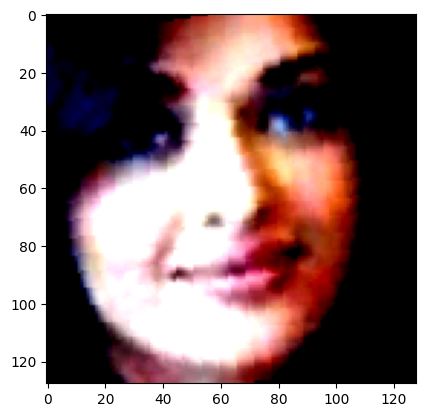

In [45]:
plt.imshow(train_combined_dataset[0][0].permute(1, 2, 0))

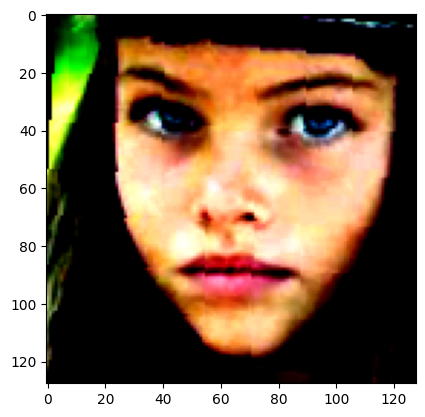

In [46]:
plt.imshow(train_combined_dataset[4][0].permute(1, 2, 0))

In [47]:
import matplotlib.pyplot as plt
import torch
import random

# Adjusted display_random_images function for multi-task dataset
def display_random_images(dataset, age_classes=None, gender_classes=None, emotion_classes=None, n=10, display_shape=True, seed=None):
    if n > 10:
        n = 10
        display_shape = False
        print("n should NOT be larger than 10")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for i, idx in enumerate(random_samples_idx):
        img_tensor, labels = dataset[idx]
        
        # Convert image tensor to numpy (PyTorch format -> Matplotlib format)
        img_np = img_tensor.permute(1, 2, 0).numpy()

        # Extract labels (age, gender, emotion)
        age_label, gender_label, emotion_label = labels.tolist()

        # Format labels correctly
        age_text = f"Age: {age_classes[age_label]}" if (age_classes and age_label != -1) else "Age: N/A"
        gender_text = f"Gender: {gender_classes[gender_label]}" if (gender_classes and gender_label != -1) else "Gender: N/A"
        emotion_text = f"Emotion: {emotion_classes[emotion_label]}" if (emotion_classes and emotion_label != -1) else "Emotion: N/A"

        # Plot image
        plt.subplot(1, n, i + 1)
        plt.imshow(img_np)
        plt.axis("off")

        # Display labels & shape info
        title = f"{age_text}\n{gender_text}\n{emotion_text}"
        if display_shape:
            title += f"\nShape: {img_tensor.shape}"
        plt.title(title, fontsize=10)

    plt.show()

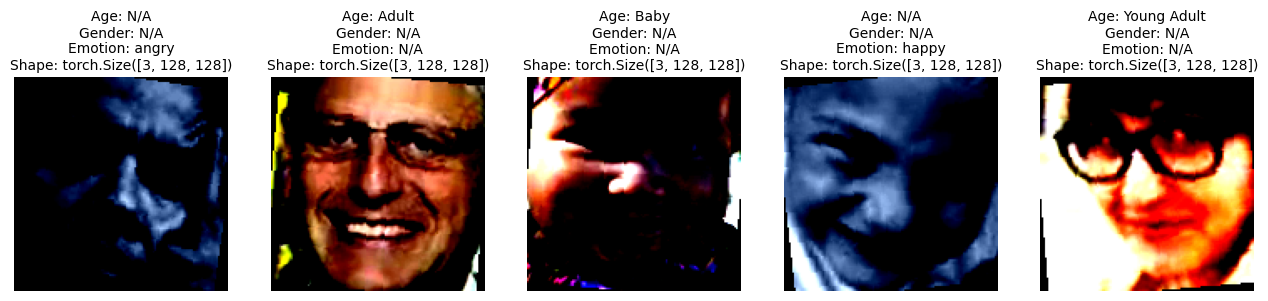

In [48]:
# Call function
display_random_images(
    dataset=train_combined_dataset,
    age_classes=age_labels,
    gender_classes=gender_labels,
    emotion_classes=emotion_labels,
    n=5,  # Display 5 images
    seed=42  # Random seed for reproducibility
)

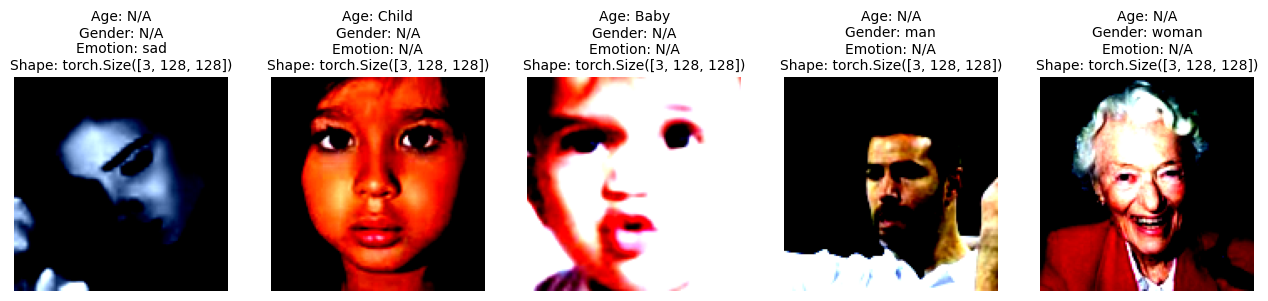

In [49]:
# Call function
display_random_images(
    dataset=test_combined_dataset,
    age_classes=age_labels,
    gender_classes=gender_labels,
    emotion_classes=emotion_labels,
    n=5,  # Display 5 images
    seed=42  # Random seed for reproducibility
)

## 5. Turn all Dataset into DataLoader

In [50]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

# Age Dataset
train_dataloader = DataLoader(dataset=train_combined_dataset, 
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_combined_dataset, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [51]:
train_images, train_labels = next(iter(train_dataloader))
train_images.shape, train_labels.shape, train_labels[:10]

(torch.Size([64, 3, 128, 128]),
 torch.Size([64, 3]),
 tensor([[-1, -1,  5],
         [ 5, -1, -1],
         [-1,  0, -1],
         [ 3, -1, -1],
         [ 2, -1, -1],
         [-1, -1,  2],
         [-1, -1,  4],
         [-1,  1, -1],
         [-1,  1, -1],
         [-1,  0, -1]]))

In [52]:
len(train_dataloader), len(test_dataloader)

(244, 94)

## Model Architecture 

In [53]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskEfficientNetV2(nn.Module):
    def __init__(self, input_shape, hidden_shape, num_age_classes, 
                 num_gender_classes, num_emotion_classes):
        
        super(MultiTaskEfficientNetV2, self).__init__()
        
        # Load EfficientNetV2 backbone (pretrained on ImageNet)
        self.backbone = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        
        # Remove the classification head
        self.backbone.classifier = nn.Identity()
        
        # Define task-specific heads
        self.age_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, num_age_classes),
        )
        
        self.gender_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, num_gender_classes),
        )
        
        self.emotion_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, num_emotion_classes),
        )
        
    def forward(self, x):
        features = self.backbone(x)  # Extract shared features
        
        age_out = self.age_head(features)
        gender_out = self.gender_head(features)
        emotion_out = self.emotion_head(features)
        
        return age_out, gender_out, emotion_out

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model Training

In [55]:
def train_step(model, dataloader, age_loss_fn, 
               gender_loss_fn, emotion_loss_fn,
               optimizer, device=device):

    """
    Perform a single training step for each epoch.

    Parameters:
        model: PyTorch multi-task model.
        dataloader: DataLoader for training data.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for age, gender, and emotion tasks.
        optimizer: Optimizer to update the model parameters.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        train_loss: Average loss over the epoch.
        train_acc: Average accuracy across all tasks.
        overall_accuracy: Dictionary of task-specific accuracies.
    """

    model.train()
    train_loss = 0
    age_acc, gender_acc, emotion_acc = 0, 0, 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

    # Forward pass
    age_pred, gender_pred, emotion_pred = model(X)

    # Initialize accumulators
    num_tasks = 0
    batch_loss = 0

    # Calculate Age Loss
    age_indices = y[:, 0] != -1
    if age_indices.sum() > 0:
        age_loss = age_loss_fn(age_pred[age_indices], y[age_indices, 0].long())
        batch_loss += age_loss
        num_tasks += 1

        # Calculate Age Accuracy
        age_pred_class = age_pred.argmax(dim=1)
        age_accuracy = (age_pred_class[age_indices] == y[age_indices, 0]).sum().item() / age_indices.sum().item()
        age_acc += age_accuracy

        # Calculate Gender Loss
        gender_indices = y[:, 1] != -1
        if gender_indices.sum() > 0:
            gender_loss = gender_loss_fn(gender_pred[gender_indices], y[gender_indices, 1].long())
            batch_loss += gender_loss
            num_tasks += 1

            # Calculate Gender Accuracy
            gender_pred_class = gender_pred.argmax(dim=1)
            gender_accuracy = (gender_pred_class[gender_indices] == y[gender_indices, 1]).sum().item() / gender_indices.sum().item()
            gender_acc += gender_accuracy

        # Calculate Emotion Loss
        emotion_indices = y[:, 2] != -1
        if emotion_indices.sum() > 0:
            emotion_loss = emotion_loss_fn(emotion_pred[emotion_indices], y[emotion_indices, 2].long())
            batch_loss += emotion_loss
            num_tasks += 1

            # Calculate Emotion Accuracy
            emotion_pred_class = emotion_pred.argmax(dim=1)
            emotion_accuracy = (emotion_pred_class[emotion_indices] == y[emotion_indices, 2]).sum().item() / emotion_indices.sum().item()
            emotion_acc += emotion_accuracy

        # Backpropagation
        optimizer.zero_grad()
        if num_tasks > 0:  # Avoid division by zero
            batch_loss = batch_loss / num_tasks
            train_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()

    # Average Loss and Accuracy
    train_loss /= num_batches
    avg_age_acc = age_acc / num_batches
    avg_gender_acc = gender_acc / num_batches
    avg_emotion_acc = emotion_acc / num_batches
    train_acc = (avg_age_acc + avg_gender_acc + avg_emotion_acc) / 3

    accuracy_info = {
        "Age Acc": round(avg_age_acc, 4), 
        "Gender Acc": round(avg_gender_acc,4),
        "Emotion Acc": round(avg_emotion_acc, 4)
    }

    return train_loss, train_acc, accuracy_info

In [56]:
def test_step(model, dataloader, age_loss_fn, gender_loss_fn, emotion_loss_fn, device=device):
    """
    Perform a single testing step.

    Parameters:
        model: PyTorch multi-head model.
        dataloader: DataLoader for test data.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for age, gender, and emotion tasks.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        test_loss: Average loss over the epoch.
        test_acc: Average accuracy across all tasks.
        overall_accuracy: Dictionary of task-specific accuracies.
    """
    model.eval()
    test_loss = 0
    age_acc, gender_acc, emotion_acc = 0, 0, 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward Pass
            age_pred, gender_pred, emotion_pred = model(X)

            # Initialize accumulators
            num_tasks = 0
            batch_loss = 0

            # Calculate Age Loss
            age_indices = y[:, 0] != -1
            if age_indices.sum() > 0:
                age_loss = age_loss_fn(age_pred[age_indices], y[age_indices, 0].long())
                batch_loss += age_loss
                num_tasks += 1

                # Age Accuracy
                age_pred_class = age_pred.argmax(dim=1)
                age_accuracy = (age_pred_class[age_indices] == y[age_indices, 0]).sum().item() / age_indices.sum().item()
                age_acc += age_accuracy

            # Calculate Gender Loss
            gender_indices = y[:, 1] != -1
            if gender_indices.sum() > 0:
                gender_loss = gender_loss_fn(gender_pred[gender_indices], y[gender_indices, 1].long())
                batch_loss += gender_loss
                num_tasks += 1

                # Gender Accuracy
                gender_pred_class = gender_pred.argmax(dim=1)
                gender_accuracy = (gender_pred_class[gender_indices] == y[gender_indices, 1]).sum().item() / gender_indices.sum().item()
                gender_acc += gender_accuracy

            # Calculate and mask Emotion Loss
            emotion_indices = y[:, 2] != -1
            if emotion_indices.sum() > 0:
                emotion_loss = emotion_loss_fn(emotion_pred[emotion_indices], y[emotion_indices, 2].long())
                batch_loss += emotion_loss
                num_tasks += 1

                # Emotion Accuracy
                emotion_pred_class = emotion_pred.argmax(dim=1)
                emotion_accuracy = (emotion_pred_class[emotion_indices] == y[emotion_indices, 2]).sum().item() / emotion_indices.sum().item()
                emotion_acc += emotion_accuracy

            # Accumulate Total Loss
            if num_tasks > 0:  # Avoid division by zero
                batch_loss = batch_loss / num_tasks
                test_loss += batch_loss.item()

    # Average Loss and Accuracy
    test_loss /= num_batches
    avg_age_acc = age_acc / num_batches
    avg_gender_acc = gender_acc / num_batches
    avg_emotion_acc = emotion_acc / num_batches
    test_acc = (avg_age_acc + avg_gender_acc + avg_emotion_acc) / 3

    accuracy_info = {
        "Age Acc": round(avg_age_acc, 4),
        "Gender Acc": round(avg_gender_acc,4), 
        "Emotion Acc": round(avg_emotion_acc, 4)
    }

    return test_loss, test_acc, accuracy_info

In [57]:
def train(model, 
          train_dataloader, 
          test_dataloader, 
          optimizer, 
          age_loss_fn, 
          gender_loss_fn, 
          emotion_loss_fn, 
          epochs, 
          device=device):
    """
    Training loop for multi-task model.

    Parameters:
        model: PyTorch multi-task model.
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for testing data.
        optimizer: Optimizer for the model.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for each task.
        epochs: Number of epochs to train the model.
        device: Device for computation (e.g., "cuda" or "cpu").

    Returns:
        results: Dictionary containing training and testing losses and accuracies.
    """
    results = {
        'train_loss': [],
        'train_acc': [],
        'train_overall_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_overall_acc': []
    }

    for epoch in range(epochs):

        # Training Step
        train_loss, train_acc, train_overall_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            age_loss_fn=age_loss_fn,
            gender_loss_fn=gender_loss_fn,
            emotion_loss_fn=emotion_loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Testing Step
        test_loss, test_acc, test_overall_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            age_loss_fn=age_loss_fn,
            gender_loss_fn=gender_loss_fn,
            emotion_loss_fn=emotion_loss_fn,
            device=device
        )
        # Logging
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        print(f"Train Overall Accuracy: {train_overall_acc}")
        print(f"Test Overall Accuracy: {test_overall_acc}")

        # Append Results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['train_overall_acc'].append(train_overall_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['test_overall_acc'].append(test_overall_acc)

    return results

In [58]:
len(age_idx), len(emotion_idx)

(6, 6)

In [59]:
EPOCHS = 15
NUM_AGE_BINS = len(age_idx)
NUM_GENDERS = 2
NUM_EMOTIONS = len(emotion_idx)

In [60]:
multi_task_model = MultiTaskEfficientNetV2(
    input_shape=1280, hidden_shape=512, 
    num_age_classes=NUM_AGE_BINS, 
    num_gender_classes=NUM_GENDERS, 
    num_emotion_classes=NUM_EMOTIONS
).to(device)

optimizer = torch.optim.Adam(multi_task_model.parameters(), lr=0.01)

age_loss_fn = nn.CrossEntropyLoss()
gender_loss_fn = nn.CrossEntropyLoss()
emotion_loss_fn = nn.CrossEntropyLoss()

# multi_task_model

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 188MB/s]


In [61]:
!pip install torchview

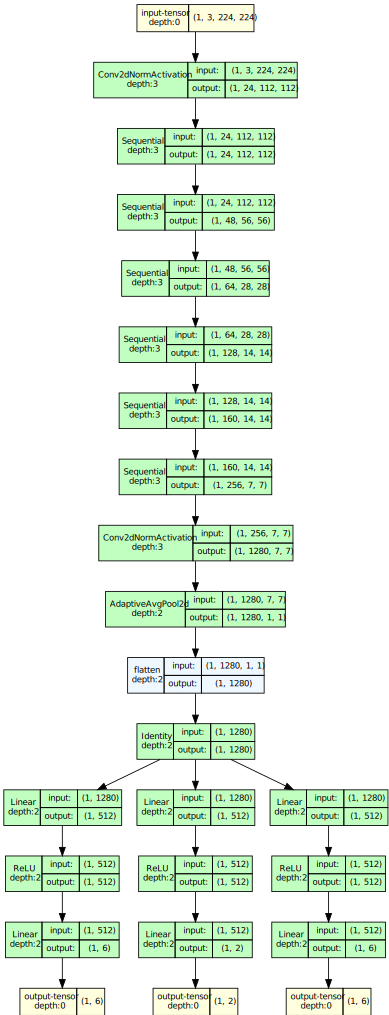

In [62]:
from torchview import draw_graph

model_graph = draw_graph(multi_task_model, input_size=(1, 3, 224, 224), 
                         device=device, roll=True, save_graph=True)
model_graph.visual_graph

In [63]:
# from timeit import default_timer as timer

# start_time = timer()

# model_results = train(model=multi_task_model, train_dataloader=train_dataloader,
#                       test_dataloader=test_dataloader, optimizer=optimizer, 
#                       age_loss_fn=age_loss_fn, gender_loss_fn=gender_loss_fn, 
#                       emotion_loss_fn=emotion_loss_fn, epochs=EPOCHS)

# end_time = timer()
# print(f'Total Training Time: {end_time - start_time:.3f} seconds')